<a href="https://colab.research.google.com/github/ravi-gopalan/disaster_response/blob/master/Disaster_response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get files

In [57]:
# Clone the entire repo.
!git clone -l -s git://github.com/ravi-gopalan/disaster_response.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 32 (delta 13), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (32/32), 3.02 MiB | 5.01 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/cloned-repo/cloned-repo
categories.csv		 LICENSE       README.md
Disaster_response.ipynb  messages.csv  Twitter-sentiment-self-drive-DFE.csv


In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Import libraries

In [0]:
# import libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
pwd

'/content/cloned-repo/cloned-repo'

# ETL Pipeline

In [61]:
# load messages dataset
messages = pd.read_csv('messages.csv')
messages.head()
# load categories dataset
categories = pd.read_csv('categories.csv')
categories.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


### There seems to be an id, a message in an original language, an English version and a genre of message

In [62]:
messages.describe(include='all')
categories.describe(include='all')

,id,message,original,genre
count,26248.000000,26248,10184,26248
unique,NaN,26177,9630,3
top,NaN,#NAME?,Nap fe ou konnen ke apati de jodi a sevis SMS ...,news
freq,NaN,4,20,13068
mean,15224.078368,NaN,NaN,NaN
std,8826.069156,NaN,NaN,NaN
min,2.000000,NaN,NaN,NaN
25%,7445.750000,NaN,NaN,NaN
50%,15660.500000,NaN,NaN,NaN
75%,22923.250000,NaN,NaN,NaN


,id,categories
count,26248.000000,26248
unique,NaN,4003
top,NaN,related-0;request-0;offer-0;aid_related-0;medi...
freq,NaN,6125
mean,15224.078368,NaN
std,8826.069156,NaN
min,2.000000,NaN
25%,7445.750000,NaN
50%,15660.500000,NaN
75%,22923.250000,NaN


In [63]:
# drop original as these are in an other language that you can't add much value
messages.drop(columns=['original'],axis=1,inplace=True)
messages.head()

,id,message,genre
0,2,Weather update - a cold front from Cuba that c...,direct
1,7,Is the Hurricane over or is it not over,direct
2,8,Looking for someone but no name,direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",direct


#### Are there duplicates? If so, how many?

In [64]:
messages[messages.duplicated(['id','message','genre'])].count()

id         68
message    68
genre      68
dtype: int64

In [65]:
#### There are 68 ids that are duplicated in the messages dataframe. Drop them
messages.drop_duplicates(inplace=True)
messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26180 entries, 0 to 26247
Data columns (total 3 columns):
id         26180 non-null int64
message    26180 non-null object
genre      26180 non-null object
dtypes: int64(1), object(2)
memory usage: 818.1+ KB


In [66]:
categories[categories.duplicated(['id','categories'])].count()

id            32
categories    32
dtype: int64

In [67]:
#### There are ~32 duplicates in the categories data frame. Drop them
categories.drop_duplicates(inplace=True)
categories.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26216 entries, 0 to 26247
Data columns (total 2 columns):
id            26216 non-null int64
categories    26216 non-null object
dtypes: int64(1), object(1)
memory usage: 614.4+ KB


In [68]:
categories[categories.duplicated(['id'])].count()

id            36
categories    36
dtype: int64

#### There are 36 ids that are duplicated but the categories are not hence these are still in the Data Frame

#### There are still some records in categories where ids are duplicated but there's something else in the categories column

###3. Split categories into separate category columns.
Split the values in the categories column on the ; character so that each value becomes a separate column. You'll find this method very helpful! Make sure to set expand=True.
Use the first row of categories dataframe to create column names for the categories data.
Rename columns of categories with new column names.

In [69]:
categories.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


In [70]:
# create a dataframe of the 36 individual category columns
categories_expanded = categories.categories.str.split(';',None,True)

categories_expanded.head()
categories.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-1,transport-0,buildings-1,electricity-0,tools-0,hospitals-1,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


In [71]:
categories_expanded.info()
categories.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26216 entries, 0 to 26247
Data columns (total 36 columns):
0     26216 non-null object
1     26216 non-null object
2     26216 non-null object
3     26216 non-null object
4     26216 non-null object
5     26216 non-null object
6     26216 non-null object
7     26216 non-null object
8     26216 non-null object
9     26216 non-null object
10    26216 non-null object
11    26216 non-null object
12    26216 non-null object
13    26216 non-null object
14    26216 non-null object
15    26216 non-null object
16    26216 non-null object
17    26216 non-null object
18    26216 non-null object
19    26216 non-null object
20    26216 non-null object
21    26216 non-null object
22    26216 non-null object
23    26216 non-null object
24    26216 non-null object
25    26216 non-null object
26    26216 non-null object
27    26216 non-null object
28    26216 non-null object
29    26216 non-null object
30    26216 non-null object
31    26216 non-null ob

In [0]:
categories_full = pd.concat([categories, categories_expanded],axis=1)

In [73]:
categories_full.drop(columns=['categories'],axis=1,inplace=True)
categories_full.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,7,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,8,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,9,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-1,transport-0,buildings-1,electricity-0,tools-0,hospitals-1,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,12,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [74]:
names = []
for x in categories_full.iloc[0]:
    names.append(x)
#column_names
names = names[1:]
columns = [name[:-2] for name in names]
columns

['related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'child_alone',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

In [75]:
columns = ['id'] + columns
columns

['id',
 'related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'child_alone',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

In [76]:
categories_full.columns = columns
categories_full.head()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,7,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,8,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,9,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-1,transport-0,buildings-1,electricity-0,tools-0,hospitals-1,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,12,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [77]:
categories_full.set_index(keys='id',inplace=True)
categories_full.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
7,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
8,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
9,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-1,transport-0,buildings-1,electricity-0,tools-0,hospitals-1,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
12,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [78]:
categories_full.columns[1:]

Index(['request', 'offer', 'aid_related', 'medical_help', 'medical_products',
       'search_and_rescue', 'security', 'military', 'child_alone', 'water',
       'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees',
       'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')

In [79]:
for column in categories_full.columns:
    # set each value to be the last character of the string
    categories_full[column] = categories_full[column].str[-1]
    
    # convert column from string to numeric
    categories_full[column] = categories_full[column].astype(int)
categories_full.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
categories_full.describe(include='all')

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.0,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,0.0,0.063778,0.111497,0.088267,0.015449,0.023039,0.011367,0.033377,0.045545,0.131446,0.065037,0.045812,0.050847,0.020293,0.006065,0.010795,0.004577,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,0.0,0.244361,0.314752,0.283688,0.123331,0.150031,0.106011,0.179621,0.208500,0.337894,0.246595,0.209081,0.219689,0.141003,0.077643,0.103338,0.067502,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### There are some rows for which the related column has value of 2 - that seems like a data quality issue
#### Also, the child_alone column has only 0

In [81]:
categories_full.query('related=="2"')['related'].count()
categories_full['related'].replace(\
                                   to_replace=2,\
                                   value=1,\
                                   inplace=True\
                                  )
categories_full.describe(include='all')

188

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.0,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,0.766478,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,0.0,0.063778,0.111497,0.088267,0.015449,0.023039,0.011367,0.033377,0.045545,0.131446,0.065037,0.045812,0.050847,0.020293,0.006065,0.010795,0.004577,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,0.423079,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,0.0,0.244361,0.314752,0.283688,0.123331,0.150031,0.106011,0.179621,0.208500,0.337894,0.246595,0.209081,0.219689,0.141003,0.077643,0.103338,0.067502,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [82]:
categories_full[categories_full.duplicated()].count()
categories_updated = categories_full.groupby(['id'])['related', 'request', 'offer', 'aid_related', \
                                          'medical_help','medical_products', 'search_and_rescue', \
                                          'security', 'military','child_alone', 'water', 'food', \
                                          'shelter', 'clothing', 'money','missing_people', 'refugees', \
                                          'death', 'other_aid','infrastructure_related', 'transport', \
                                          'buildings', 'electricity','tools', 'hospitals', 'shops', \
                                          'aid_centers', 'other_infrastructure','weather_related', \
                                          'floods', 'storm', 'fire', 'earthquake', 'cold',\
                                          'other_weather', 'direct_report'].agg('max').reset_index()
categories_updated.head()
categories_updated.info()

related                   22214
request                   22214
offer                     22214
aid_related               22214
medical_help              22214
medical_products          22214
search_and_rescue         22214
security                  22214
military                  22214
child_alone               22214
water                     22214
food                      22214
shelter                   22214
clothing                  22214
money                     22214
missing_people            22214
refugees                  22214
death                     22214
other_aid                 22214
infrastructure_related    22214
transport                 22214
buildings                 22214
electricity               22214
tools                     22214
hospitals                 22214
shops                     22214
aid_centers               22214
other_infrastructure      22214
weather_related           22214
floods                    22214
storm                     22214
fire    

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26180 entries, 0 to 26179
Data columns (total 37 columns):
id                        26180 non-null int64
related                   26180 non-null int64
request                   26180 non-null int64
offer                     26180 non-null int64
aid_related               26180 non-null int64
medical_help              26180 non-null int64
medical_products          26180 non-null int64
search_and_rescue         26180 non-null int64
security                  26180 non-null int64
military                  26180 non-null int64
child_alone               26180 non-null int64
water                     26180 non-null int64
food                      26180 non-null int64
shelter                   26180 non-null int64
clothing                  26180 non-null int64
money                     26180 non-null int64
missing_people            26180 non-null int64
refugees                  26180 non-null int64
death                     26180 non-null int6

In [83]:
# Remove child_alone column as all values are 0 and there is no variation
categories_updated.drop(columns=['child_alone'],axis=1,inplace=True)
categories_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26180 entries, 0 to 26179
Data columns (total 36 columns):
id                        26180 non-null int64
related                   26180 non-null int64
request                   26180 non-null int64
offer                     26180 non-null int64
aid_related               26180 non-null int64
medical_help              26180 non-null int64
medical_products          26180 non-null int64
search_and_rescue         26180 non-null int64
security                  26180 non-null int64
military                  26180 non-null int64
water                     26180 non-null int64
food                      26180 non-null int64
shelter                   26180 non-null int64
clothing                  26180 non-null int64
money                     26180 non-null int64
missing_people            26180 non-null int64
refugees                  26180 non-null int64
death                     26180 non-null int64
other_aid                 26180 non-null int6

# Merge the DataFrames

### There are same number of records in messages and categories

In [84]:
# merge datasets
df = messages.merge(categories_updated, how='left',on='id')
df.head()

,id,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [85]:
df.describe(include='all')

,id,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26180.000000,26180,26180,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000
unique,NaN,26177,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,#NAME?,news,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,13039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,15227.563942,NaN,NaN,0.766501,0.170626,0.004507,0.414171,0.079565,0.050115,0.027655,0.017991,0.032850,0.063751,0.111421,0.088197,0.015432,0.023033,0.011383,0.033422,0.045531,0.131474,0.065126,0.045798,0.050840,0.020321,0.006073,0.010810,0.004584,0.011803,0.043965,0.278304,0.082086,0.093239,0.010772,0.093659,0.020206,0.052559,0.193583
std,8827.269301,NaN,NaN,0.423065,0.376189,0.066986,0.492588,0.270623,0.218186,0.163985,0.132920,0.178246,0.244313,0.314659,0.283587,0.123264,0.150011,0.106083,0.179740,0.208470,0.337925,0.246753,0.209051,0.219676,0.141098,0.077696,0.103409,0.067549,0.108000,0.205021,0.448172,0.274500,0.290773,0.103228,0.291360,0.140708,0.223156,0.395113
min,2.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7449.750000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15665.500000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22927.250000,NaN,NaN,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### #NAME? seems to be a message thats been duplicated

In [86]:
df.drop(df.index[df['message'] == "#NAME?"], inplace = True)
df.describe(include='all')

,id,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26176.000000,26176,26176,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000,26176.000000
unique,NaN,26176,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,The tripartite group is made up of officials f...,news,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,13035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,15226.183985,NaN,NaN,0.766542,0.170653,0.004470,0.414196,0.079539,0.050084,0.027659,0.017994,0.032855,0.063761,0.111438,0.088211,0.015434,0.023036,0.011384,0.033428,0.045538,0.131494,0.065136,0.045805,0.050848,0.020324,0.006074,0.010811,0.004584,0.011805,0.043972,0.278347,0.082098,0.093253,0.010773,0.093674,0.020209,0.052567,0.193574
std,8827.169602,NaN,NaN,0.423039,0.376212,0.066708,0.492592,0.270583,0.218123,0.163997,0.132930,0.178259,0.244331,0.314680,0.283606,0.123274,0.150022,0.106091,0.179754,0.208485,0.337947,0.246770,0.209067,0.219692,0.141109,0.077702,0.103416,0.067554,0.108008,0.205036,0.448194,0.274519,0.290793,0.103236,0.291380,0.140718,0.223172,0.395107
min,2.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7448.750000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15663.500000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22925.250000,NaN,NaN,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Whats the correlation between the categories column

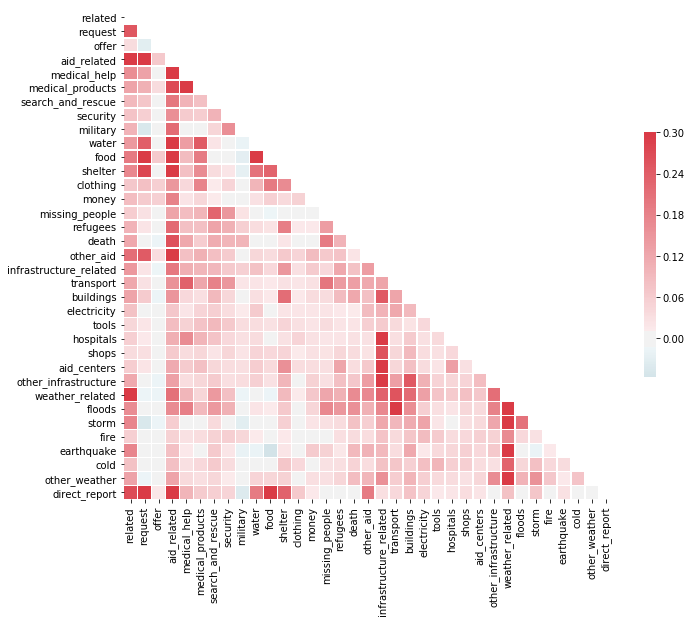

In [87]:
corr = df.drop(columns=['id','message','genre']).corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [88]:
for column in df.columns[3:]:
    print("---{}---".format(column))
    print(df[column].value_counts())

---related---
1    20065
0     6111
Name: related, dtype: int64
---request---
0    21709
1     4467
Name: request, dtype: int64
---offer---
0    26059
1      117
Name: offer, dtype: int64
---aid_related---
0    15334
1    10842
Name: aid_related, dtype: int64
---medical_help---
0    24094
1     2082
Name: medical_help, dtype: int64
---medical_products---
0    24865
1     1311
Name: medical_products, dtype: int64
---search_and_rescue---
0    25452
1      724
Name: search_and_rescue, dtype: int64
---security---
0    25705
1      471
Name: security, dtype: int64
---military---
0    25316
1      860
Name: military, dtype: int64
---water---
0    24507
1     1669
Name: water, dtype: int64
---food---
0    23259
1     2917
Name: food, dtype: int64
---shelter---
0    23867
1     2309
Name: shelter, dtype: int64
---clothing---
0    25772
1      404
Name: clothing, dtype: int64
---money---
0    25573
1      603
Name: money, dtype: int64
---missing_people---
0    25878
1      298
Name: missing_peo

In [89]:
# check number of duplicates
df[df.duplicated()].count()

id                        0
message                   0
genre                     0
related                   0
request                   0
offer                     0
aid_related               0
medical_help              0
medical_products          0
search_and_rescue         0
security                  0
military                  0
water                     0
food                      0
shelter                   0
clothing                  0
money                     0
missing_people            0
refugees                  0
death                     0
other_aid                 0
infrastructure_related    0
transport                 0
buildings                 0
electricity               0
tools                     0
hospitals                 0
shops                     0
aid_centers               0
other_infrastructure      0
weather_related           0
floods                    0
storm                     0
fire                      0
earthquake                0
cold                

In [0]:
from sqlalchemy import create_engine

In [0]:
engine = create_engine('sqlite:///Disaster.db')
df.to_sql('messages', engine, index=False, if_exists='replace')

# NLP & ML Pipeline

In [92]:
import re
import nltk
nltk.download(['stopwords','punkt','wordnet'])
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet

from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import timeit
import joblib

In [0]:
def load_data():
    # load data from database
    '''
    This function creates a connection to the sqlite database and loads the data from the messages table as a pandas dataframe. 
    It further creates the features and outputs as 2 dataframes

    Input: None
    Outputs: 
    X values which are the actual tweet messages,
    y values which are the multi-output classifications of the tweets
    category_names which is a list of the various classification types   
    '''
    engine = create_engine('sqlite:///Disaster.db')
    connection = engine.connect()

    df = pd.read_sql_table('messages', connection)
    X = df['message'].values
    y = df.drop(columns=['id','message','genre'],axis=1).values
    category_names = list(df.columns[3:])
    return X, y, category_names

In [0]:
def tokenize(text):

    '''
    This function a list of normalized tokens from an input text. 
    The messages are first converted into a list of words after removing common stopwords.
    These are then lemmatized and then also converted into lower case and punctuations and special characters are removed 
    The final list of clean word tokens are then provided as output

    Input: text (disaster message)
    Outputs: 
    list of lemmatized, lower-case words with punctuations and special characters removed 
   
    '''

    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # iterate through each token
    clean_tokens = []
    for tok in tokens:
        lemmed = lemmatizer.lemmatize(tok, pos='v')
        # lemmatize, normalize case, and remove leading/trailing white space
        clean_tok = re.sub(r"[^a-zA-Z0-9]"," ",lemmed.lower()).strip()
        clean_tokens.append(clean_tok)
    return clean_tokens

In [0]:
def display_results(y_test, y_pred, category_names):

    '''
    This function creates an evaluation report of the predicted classifications vs actual classifications.
    The report lists out metrics such as precision, recall, f1, accuracy and kappa for each of the categories


    Input: y_test (an array of the test set results), y_pred (an array of the predicted categories), list of categories
    Outputs: 
    DataFrame of report showing the key classification metrics such as precision, recall, f1, accuracy and kappa for each of the categories 

    '''

    list_of_reports = []
    
    for col in range(len(category_names)):
        report_metric = {}
        y1 = y_test.T[col]
        y2 = y_pred.T[col]
        # report_metric['category'] = category_names[col]
        report_metric['precision'] = precision_score(y1,y2 )
        report_metric['recall'] = recall_score(y1,y2)
        report_metric['f1'] = f1_score(y1,y2)
        report_metric['accuracy'] = accuracy_score(y1,y2)
        report_metric['kappa'] = cohen_kappa_score(y1,y2)
        list_of_reports.append(report_metric)
    performance_metrics = pd.DataFrame(list_of_reports)
    return performance_metrics

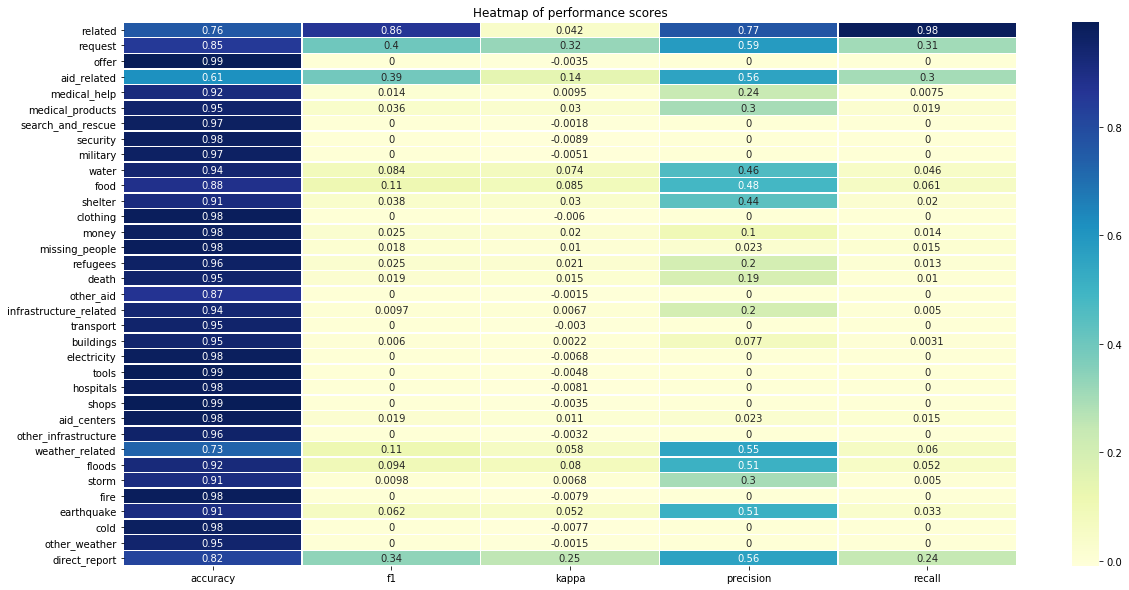

In [97]:
def main():

    '''
    This function runs an ETL pipeline. 
    It first loads the dataset from the database.
    Then it creates the split of training and test sets
    Thereafter it creates a pipeline including CountVectorizer, TfidfTransformer, TruncatedSVD, MuliOutputClassifier.
    It then fits the pipeline and then uses the model to predict on the training set.
    Then it evaluates the result of the prediction.
    A heatmap is also created for the results.
    The model is then pickled

    Input: None
    Outputs: None 

    '''

    X, y, category_names = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    

    # print(category_names)
    # build pipeline
    pipeline = Pipeline([('vect',CountVectorizer(tokenizer=tokenize)),\
                         ('tfidf',TfidfTransformer()),\
                         ('best', TruncatedSVD()),\
                         ('clf',MultiOutputClassifier(\
                                                      GradientBoostingClassifier(random_state=42)))\
                        ])
         
    # train classifier
    pipeline.fit(X_train, y_train)

    # predict on test data
    y_pred = pipeline.predict(X_test)

    # print(y_test.shape, y_pred.shape, y_test.T.shape, y_pred.T.shape)

    # display results
    performance_report = display_results(y_test, y_pred, category_names)
    
    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(20, 10));
    sns.heatmap(performance_report, annot=True, linewidths=.5, ax=ax, yticklabels=category_names,cmap="YlGnBu").set_title('Heatmap of performance scores');
    joblib.dump(pipeline,'classifier.pkl')

main()

## Use GridSearch to improve the model

In [98]:
parameters = {'clf__estimator__n_estimators': [150],\
              'clf__estimator__min_samples_split': [4,5]
             }


X, y, category_names = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y)

pipeline = Pipeline([('tfidfvect',TfidfVectorizer(tokenizer=tokenize)),\
                     ('best', TruncatedSVD()),\
                     ('clf',MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)))\
                        ])

start_time = timeit.default_timer()
gscv = GridSearchCV(estimator=pipeline,\
                    param_grid=parameters,\
                    scoring=['accuracy','precision_micro','recall_micro','f1_micro'],\
                    refit='precision_micro',\
                    cv=3 \
                    )

gscv.fit(X_train, y_train)
gscv.best_params_

stop_time = timeit.default_timer()
print('Execution Time: \n {}'.format(stop_time - start_time))



Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sqlalchemy/pool/base.py", line 680, in _finalize_fairy
    fairy._reset(pool)
  File "/usr/local/lib/python3.6/dist-packages/sqlalchemy/pool/base.py", line 867, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.6/dist-packages/sqlalchemy/engine/default.py", line 502, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140668616341376 and this is thread id 140667433776896.
Exception closing connection <sqlite3.Connection object at 0x7fefa9814570>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sqlalchemy/pool/base.py", line 680, in _finalize_fairy
    fairy._reset(pool)
  File "/usr/local/lib/python3.6/dist-packages/sqlalchemy/pool/base.py", line 867, in _reset
    pool._dialect.do_rol

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                     

{'clf__estimator__min_samples_split': 5, 'clf__estimator__n_estimators': 150}

Execution Time: 
 1308.4000609590003


In [99]:
gscv.best_params_

{'clf__estimator__min_samples_split': 5, 'clf__estimator__n_estimators': 150}

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


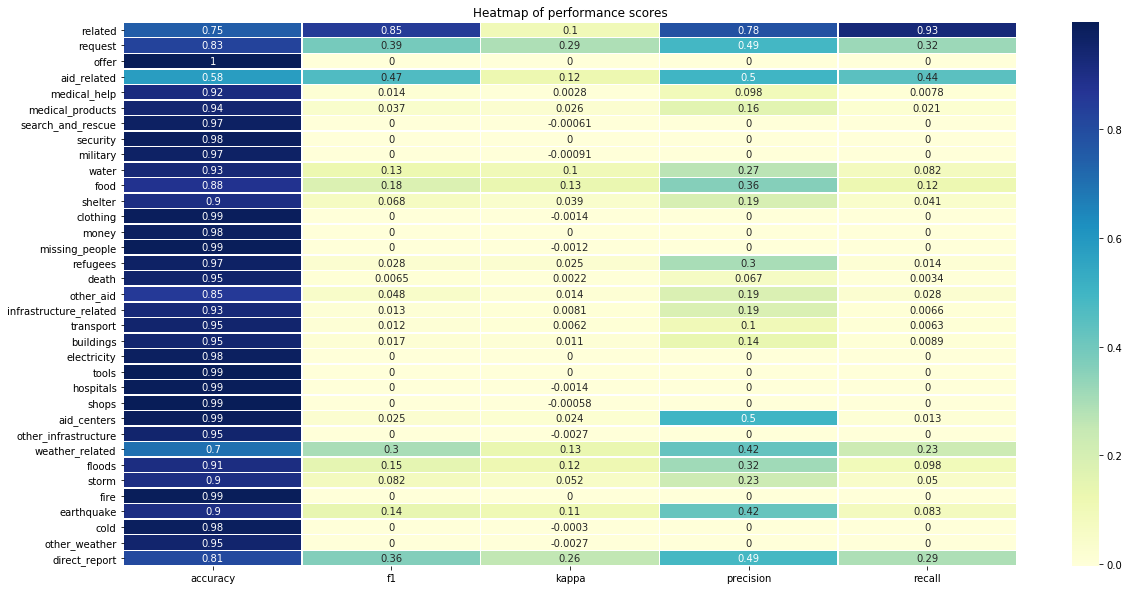

In [100]:
y_pred_new = gscv.predict(X_test)

# print(y_test.shape, y_pred.shape, y_test.T.shape, y_pred.T.shape)

# display results
performance_report_new = display_results(y_test, y_pred_new, category_names)
    
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(20, 10));
sns.heatmap(performance_report_new, annot=True, linewidths=.5, ax=ax, yticklabels=category_names,cmap="YlGnBu").set_title('Heatmap of performance scores');

In [101]:
joblib.dump(gscv.best_estimator_, 'classifier.pkl')

['classifier.pkl']